In [1]:
import pandas as pd
import geopandas as gp 
import numpy as np 
from pandas import read_csv
import requests
from math import sqrt
import os

## VEST documentation

Louisiana
---------
Election results from LA Secretary of State: https://voterportal.sos.la.gov/static/2016-11-08
Precinct shapefile from LA House of Representatives: http://house.louisiana.gov/H_Redistricting2011/default_LouisianaPrecinctShapefiles

Absentee votes and provisional ballots were reported at the parish level. These were distributed by candidate to precincts based on their share of the precinct-level reported vote.

Election results from the following parishes include "alpha" precincts in which voters within the same geographic boundaries are assigned to separate precincts by the first letter of their surname: Ascension, Assumption, Bossier, Caddo, East Baton Rouge, Lafayette, Lafourche, Rapides, St. Charles, St. Landry, Terrebonne

The following precincts were modified to reflect alterations enacted prior to the 2016 election:

Avoyelles: Merge 2-5B/6-1A
Plaquemines: Merge 2-1/2-2, 4-1/4-2, 5-1/5-2
St. Charles: Merge 2-6/2-7, 3-1/3-6, 3-3/3-4, 6-2/6-3, 6-4/6-5
Vermilion: Split 49B-1/49B-2
West Baton Rouge: Split 2-A/2-B; 11-A/11-B

G16PRERTRU - Donald J. Trump (Republican Party)
G16PREDCLI - Hillary Clinton (Democratic Party)
G16PRELJOH - Gary Johnson (Libertarian Party)
G16PREGSTE - Jill Stein (Green Party)
G16PREOMCM - Evan McMullin (Courage Character Service Party)
G16PRECCAS - Darrell Castle (Constitution Party)
G16PREOOTH - Other Candidates

G16USSRKEN - John Kennedy (Republican Party)
G16USSRBOU - Charles Boustany (Republican Party)
G16USSRFLE - John Fleming (Republican Party)
G16USSRMAN - Rob Maness (Republican Party)
G16USSRDUK - David Duke (Republican Party)
G16USSRCRA - Donald "Crawdaddy" Crawford (Republican Party)
G16USSRCAO - Joseph Cao (Republican Party)
G16USSRMAR - Charles Marsala (Republican Party)
G16USSRPAT - Abhay Patel (Republican Party)
G16USSDCAM - Foster Campbell (Democratic Party)
G16USSDFAY - Caroline Fayard (Democratic Party)
G16USSDEDW - Derrick Edwards (Democratic Party)
G16USSDLAN - Gary Landrieu (Democratic Party)
G16USSDPEL - Joshua Pellerin (Democratic Party)
G16USSDWIL - Peter Williams (Democratic Party)
G16USSDMEN - MV "Vinny" Mendoza (Democratic Party)
G16USSLCLE - Thomas P. Clements (Libertarian Party)
G16USSLGIL - Le Roy Gillam (Libertarian Party)
G16USSOLAN - William Robert "Bob" Lang, Jr. (Other Party)
G16USSOTAY - Gregory Taylor, Jr. (Other Party)
G16USSNBIL - Beryl Billiot (No Party Affiliation)
G16USSNHEB - Troy Hebert (No Party Affiliation)
G16USSNMAR - Kaitlin Marone (No Party Affiliation)
G16USSNWEL - Arden Wells (No Party Affiliation)

R16USSRKEN - John Kennedy (Republican Party)
R16USSDCAM - Foster Campbell (Democratic Party)

## Links for data

Election data: https://voterportal.sos.la.gov/graphical

Precinct shapefile from LA House of Representatives: https://house.louisiana.gov/H_redistricting2011/Shapefiles/2016%20LA%20Precincts%20for%20the%20Web.zip

## Load datasets

In [2]:
#Presidential Race -- General Election
GPRES16 = pd.read_csv('./raw-data/GPRES16.csv')

#US Senate -- General Election
GUSS16 = pd.read_csv('./raw-data/GUSS16.csv')

#US Senate -- Run-off
RUSS16 = pd.read_csv('./raw-data/RUSS16.csv')

#Load precinct shapefile
precincts = gp.read_file('./raw-data/2016_LouisianaPrecinctShapefile/2016_LA_Precincts.shp')

#Load final VEST file
final = gp.read_file('./raw-data/vest/la_2016.shp')

#Set options for pandas displays
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



### Examine the wards and VEST files


In [3]:
print(final.shape)
final.head()

(3704, 38)


,STATEFP10,COUNTYFP10,VTDST10,NAME10,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOMCM,G16PRECCAS,G16PREOOTH,G16USSRKEN,G16USSRBOU,G16USSRFLE,G16USSRMAN,G16USSRDUK,G16USSRCRA,G16USSRCAO,G16USSRMAR,G16USSRPAT,G16USSDCAM,G16USSDFAY,G16USSDEDW,G16USSDLAN,G16USSDPEL,G16USSDWIL,G16USSDMEN,G16USSLCLE,G16USSLGIL,G16USSOLAN,G16USSOTAY,G16USSNBIL,G16USSNHEB,G16USSNMAR,G16USSNWEL,R16USSRKEN,R16USSDCAM,geometry
0,22,111,24,Precinct 24,313,142,1,4,0,0,1,117,25,110,20,20,7,1,3,0,89,41,8,10,0,3,1,0,0,0,0,4,0,2,0,144,82,"POLYGON ((-92.34486 33.01065, -92.34482 33.010..."
1,22,113,23,Precinct 23,482,61,7,6,3,2,0,87,313,17,46,7,1,0,3,0,24,19,4,0,2,5,1,0,0,0,0,1,11,1,0,288,43,"POLYGON ((-92.04562 29.50581, -92.04734 29.506..."
2,22,113,16,Precinct 16,129,8,1,0,0,0,0,50,68,5,9,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,100,3,"POLYGON ((-92.25397 29.80451, -92.24874 29.802..."
3,22,111,22,Precinct 22,474,34,1,0,4,3,1,178,37,160,26,22,13,5,3,0,28,21,0,0,0,0,0,1,0,0,0,2,0,0,0,225,29,"POLYGON ((-92.31067 32.84022, -92.31052 32.840..."
4,22,113,14,Precinct 14,899,102,12,2,1,3,7,203,527,20,102,22,13,5,0,0,62,16,5,4,0,1,0,1,0,3,2,6,7,1,0,387,94,"POLYGON ((-92.22548 29.94786, -92.22548 29.947..."


In [4]:
print(precincts.shape)
precincts.head()

(3710, 32)


,ID,AREA,OBJECTID,STATEFP10,COUNTYFP10,VTDST10,GEOID10,VTDI10,NAME10,NAMELSAD10,LSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,UNITNUM,UNIT_CODE,GLEVEL,UNIT_NAME,COUNTY,MCD,PLACE,VTD,TRACT,BGROUP,BLOCK,TOT_POP,SHAPE_AREA,SHAPE_LEN,geometry
0,3205,147.168381,3360,22,111,24,2211124,A,Precinct 24,Precinct 24,00,G5240,N,341463545,2143176,+32.9337075,-092.1876878,3360.0,2211124,V,Precinct 24,111,None,None,24,None,None,None,961,0.03673,1.254069,"POLYGON ((-92.34486 33.01065, -92.34482 33.010..."
1,2240,239.121475,3396,22,113,23,2211323,A,Precinct 23,Precinct 23,00,G5240,N,436216539,182374688,+29.6044886,-092.1804148,3396.0,2211323,V,Precinct 23,113,None,None,23,None,None,None,1175,0.05765,2.019706,"POLYGON ((-92.04562 29.50581, -92.04734 29.506..."
2,2254,392.914185,3371,22,113,16,2211316,A,Precinct 16,Precinct 16,00,G5240,N,574313688,442081835,+29.6692492,-092.3925271,3371.0,2211316,V,Precinct 16,113,None,None,16,None,None,None,166,0.09470,1.493221,"POLYGON ((-92.25397 29.80451, -92.24874 29.802..."
3,3023,29.314260,3352,22,111,22,2211122,A,Precinct 22,Precinct 22,00,G5240,N,78352574,5498604,+32.7742891,-092.3236689,3352.0,2211122,V,Precinct 22,111,None,None,22,None,None,None,1090,0.00730,0.574391,"POLYGON ((-92.31067 32.84022, -92.31052 32.840..."
4,3527,202.215469,3401,22,113,14,2211314,A,Precinct 14,Precinct 14,00,G5240,N,144538801,975020,+29.9180729,-092.3134320,3401.0,2211314,V,Precinct 14,113,None,None,14,None,None,None,2403,0.04884,1.063200,"POLYGON ((-92.22548 29.94786, -92.22548 29.947..."


## Modify election data (alpha parishes and early vote)

### View the election data columns

In [5]:
print(GPRES16.columns)
print(GUSS16.columns)
print(RUSS16.columns)

Index(['Office', 'Parish', 'Ward', 'Precinct',
       'Hillary Clinton, Timothy Kaine Democratic (DEM)',
       'Jill Stein, Ajamu Baraka Green (GRN)',
       'Gary Johnson, Bill Weld Libertarian (LBT)',
       'Donald Trump, Michael Pence Republican (REP)',
       'Darrell Castle, Scott Bradley Constitution Party Nominee (OTH)',
       'Evan McMullin, Nathan Johnson Courage Character Service (OTH)',
       'Laurence Kotlikoff, Edward Lea It's Our Children (OTH)',
       'Tom Hoefling, Steve Schulin Life, Family, Constitution (OTH)',
       'Princess Jacob, Milton Fambro Loyal Trustworthy Compassion (OTH)',
       'Gloria La Riva, Eugene Puryear Socialism and Liberation (OTH)',
       'Jerry White, Niles Niemuth Socialism Equality Anti-War (OTH)',
       'Alyson Kennedy, Osborne Hart Socialist Workers Party (OTH)',
       'Chris Keniston, Deacon Taylor Veterans Party (OTH)'],
      dtype='object')
Index(['Office', 'Parish', 'Ward', 'Precinct', 'Beryl Billiot (NOPTY)',
       'Charles B

### View the final VEST  columns


In [6]:
print(final.columns)

Index(['STATEFP10', 'COUNTYFP10', 'VTDST10', 'NAME10', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOMCM', 'G16PRECCAS',
       'G16PREOOTH', 'G16USSRKEN', 'G16USSRBOU', 'G16USSRFLE', 'G16USSRMAN',
       'G16USSRDUK', 'G16USSRCRA', 'G16USSRCAO', 'G16USSRMAR', 'G16USSRPAT',
       'G16USSDCAM', 'G16USSDFAY', 'G16USSDEDW', 'G16USSDLAN', 'G16USSDPEL',
       'G16USSDWIL', 'G16USSDMEN', 'G16USSLCLE', 'G16USSLGIL', 'G16USSOLAN',
       'G16USSOTAY', 'G16USSNBIL', 'G16USSNHEB', 'G16USSNMAR', 'G16USSNWEL',
       'R16USSRKEN', 'R16USSDCAM', 'geometry'],
      dtype='object')


### Calculate the 'G16PREOOTH' field

In [7]:
GPRES16['G16PREOOTH'] = GPRES16.apply(lambda x: x["Laurence Kotlikoff, Edward Lea It's Our Children (OTH)"]+
                                      x["Tom Hoefling, Steve Schulin Life, Family, Constitution (OTH)"]+
                                      x["Princess Jacob, Milton Fambro Loyal Trustworthy Compassion (OTH)"]+
                                      x["Gloria La Riva, Eugene Puryear Socialism and Liberation (OTH)"]+
                                      x["Jerry White, Niles Niemuth Socialism Equality Anti-War (OTH)"]+
                                      x["Alyson Kennedy, Osborne Hart Socialist Workers Party (OTH)"]+
                                      x["Chris Keniston, Deacon Taylor Veterans Party (OTH)"], axis =1)
GPRES16 = GPRES16[['Office', 'Parish', 'Ward', 'Precinct',
                    'Donald Trump, Michael Pence Republican (REP)',
                   'Hillary Clinton, Timothy Kaine Democratic (DEM)',
                   'Gary Johnson, Bill Weld Libertarian (LBT)',
                   'Jill Stein, Ajamu Baraka Green (GRN)',  
                   'Evan McMullin, Nathan Johnson Courage Character Service (OTH)',
                   'Darrell Castle, Scott Bradley Constitution Party Nominee (OTH)',
                   'G16PREOOTH']]

### Rename the election dataset fields to match those in the VEST file


In [8]:
#Create a rename dictionary for SoSP file based on the corresponding fields in the VEST file
pres_rename = {"Hillary Clinton, Timothy Kaine Democratic (DEM)":"G16PREDCLI",
       "Jill Stein, Ajamu Baraka Green (GRN)":"G16PREGSTE",
       "Gary Johnson, Bill Weld Libertarian (LBT)": "G16PRELJOH",
       "Donald Trump, Michael Pence Republican (REP)":"G16PRERTRU",
       "Darrell Castle, Scott Bradley Constitution Party Nominee (OTH)":"G16PRECCAS",
       "Evan McMullin, Nathan Johnson Courage Character Service (OTH)":"G16PREOMCM"}
gsenate_rename = {'Beryl Billiot (NOPTY)':'G16USSNBIL',
       'Charles Boustany (REP)':'G16USSRBOU', 'Foster Campbell (DEM)':'G16USSDCAM', '"Joseph" Cao (REP)':'G16USSRCAO',
       'Thomas P. Clements (LBT)':'G16USSLCLE', 'Donald "Crawdaddy" Crawford (REP)':'G16USSRCRA',
       'David Duke (REP)':'G16USSRDUK', 'Derrick Edwards (DEM)':'G16USSDEDW', 'Caroline Fayard (DEM)':'G16USSDFAY',
       'John Fleming (REP)':'G16USSRFLE', 'Le Roy Gillam (LBT)':'G16USSLGIL', 'Troy Hebert (NOPTY)':'G16USSNHEB',
       'John Kennedy (REP)':'G16USSRKEN', 'Gary Landrieu (DEM)':'G16USSDLAN',
       'William Robert "Bob" Lang, Jr. (OTH)':'G16USSOLAN', '"Rob" Maness (REP)':'G16USSRMAN',
       'Kaitlin Marone (NOPTY)':'G16USSNMAR', 'Charles Marsala (REP)':'G16USSRMAR',
       'MV "Vinny" Mendoza (DEM)':'G16USSDMEN', 'Abhay Patel (REP)':'G16USSRPAT',
       'Joshua Pellerin (DEM)':'G16USSDPEL', 'Gregory Taylor, Jr. (OTH)':'G16USSOTAY',
       'Arden Wells (NOPTY)':'G16USSNWEL', 'Peter Williams (DEM)':'G16USSDWIL'}
rsenate_rename = {'Foster Campbell (DEM)':'R16USSDCAM','John Kennedy (REP)':'R16USSRKEN'}

In [9]:
#Rename the files

GPRES16.rename(columns = pres_rename, inplace=True)
GUSS16.rename(columns = gsenate_rename,inplace=True)
RUSS16.rename(columns = rsenate_rename,inplace=True)


GUSS16 = GUSS16[['Office', 'Parish', 'Ward', 'Precinct',
        'G16USSRKEN', 'G16USSRBOU', 'G16USSRFLE', 'G16USSRMAN',
       'G16USSRDUK', 'G16USSRCRA', 'G16USSRCAO', 'G16USSRMAR', 'G16USSRPAT',
       'G16USSDCAM', 'G16USSDFAY', 'G16USSDEDW', 'G16USSDLAN', 'G16USSDPEL',
       'G16USSDWIL', 'G16USSDMEN', 'G16USSLCLE', 'G16USSLGIL', 'G16USSOLAN',
       'G16USSOTAY', 'G16USSNBIL', 'G16USSNHEB', 'G16USSNMAR', 'G16USSNWEL']]

RUSS16 = RUSS16[['Office', 'Parish', 'Ward', 'Precinct',
                'R16USSRKEN', 'R16USSDCAM']]

### View the the column names of the election results and the final VEST file

In [10]:
print('GPRES16 columns: ', GPRES16.columns)
print('GUSS16 columns: ', GUSS16.columns)
print('RUSS16 columns: ', RUSS16.columns)
print('VEST columns: ', final.columns)

GPRES16 columns:  Index(['Office', 'Parish', 'Ward', 'Precinct', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16PREGSTE', 'G16PREOMCM', 'G16PRECCAS', 'G16PREOOTH'],
      dtype='object')
GUSS16 columns:  Index(['Office', 'Parish', 'Ward', 'Precinct', 'G16USSRKEN', 'G16USSRBOU',
       'G16USSRFLE', 'G16USSRMAN', 'G16USSRDUK', 'G16USSRCRA', 'G16USSRCAO',
       'G16USSRMAR', 'G16USSRPAT', 'G16USSDCAM', 'G16USSDFAY', 'G16USSDEDW',
       'G16USSDLAN', 'G16USSDPEL', 'G16USSDWIL', 'G16USSDMEN', 'G16USSLCLE',
       'G16USSLGIL', 'G16USSOLAN', 'G16USSOTAY', 'G16USSNBIL', 'G16USSNHEB',
       'G16USSNMAR', 'G16USSNWEL'],
      dtype='object')
RUSS16 columns:  Index(['Office', 'Parish', 'Ward', 'Precinct', 'R16USSRKEN', 'R16USSDCAM'], dtype='object')
VEST columns:  Index(['STATEFP10', 'COUNTYFP10', 'VTDST10', 'NAME10', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOMCM', 'G16PRECCAS',
       'G16PREOOTH', 'G16USSRKEN', 'G16USSRBOU', 'G16USSRFLE', 'G16USSRMAN',
  

### Create a function to retrieve the totals of all of the columns

In [11]:
'''This function returns a dictionary of election results column names and totals for a dataframe.
Input: pandas dataframe
Output: dictionary with column name as key and the total sum of the column as the value'''

def get_column_totals(df):
    column_totals = [] #list for column sums 
    column_name = [] #list for column names
    for i in df.columns:
        if '16' in i: #only election results in the df
            df[i] = df[i].astype(float) #converts the column to float
            column_name.append(i) #add the column name to list of column names
            col_tot = df[i].sum() #gets the sume of the column
            col_tot = round(col_tot,0) #rounds the column total to nearest whole number
            column_totals.append(col_tot) #adds the column total to the list of column sums
    tot_dict = dict(zip(column_name,column_totals)) #zips the two lists into a dictionary
    return tot_dict #returns the dictionary


In [12]:
GPRES16_tot = get_column_totals(GPRES16)
GUSS16_tot = get_column_totals(GUSS16)
RUSS16_tot = get_column_totals(RUSS16)
final_tot = get_column_totals(final)
GPRES16_tot.update(GUSS16_tot) #appends the SoSG_tot to the SoSP_tot dict (as this is the order that they are in the VEST file)
GPRES16_tot.update(RUSS16_tot)
election_tot = GPRES16_tot
GPRES16_tot = get_column_totals(GPRES16) #reruns SoSP_tot for SosP
print('GPRES16 dictionary: ', GPRES16_tot)
print('\nGUSS16 dictionary: ', GUSS16_tot)
print('\nRUSS16 dictionary: ', RUSS16_tot)
print('\nTotal election dictionary: ', election_tot)
print('\nVEST dictionary: ', final_tot)
matching = election_tot == final_tot #boolean result between raw data and final election results 
print('\nDo the election totals between the raw data and the final VEST file match (T/F)? ', str(matching))

GPRES16 dictionary:  {'G16PRERTRU': 1178638.0, 'G16PREDCLI': 780154.0, 'G16PRELJOH': 37978.0, 'G16PREGSTE': 14031.0, 'G16PREOMCM': 8547.0, 'G16PRECCAS': 3129.0, 'G16PREOOTH': 6555.0}

GUSS16 dictionary:  {'G16USSRKEN': 482591.0, 'G16USSRBOU': 298008.0, 'G16USSRFLE': 204026.0, 'G16USSRMAN': 90856.0, 'G16USSRDUK': 58606.0, 'G16USSRCRA': 25523.0, 'G16USSRCAO': 21019.0, 'G16USSRMAR': 3684.0, 'G16USSRPAT': 1576.0, 'G16USSDCAM': 337833.0, 'G16USSDFAY': 240917.0, 'G16USSDEDW': 51774.0, 'G16USSDLAN': 45587.0, 'G16USSDPEL': 7395.0, 'G16USSDWIL': 6855.0, 'G16USSDMEN': 4927.0, 'G16USSLCLE': 11370.0, 'G16USSLGIL': 4067.0, 'G16USSOLAN': 1424.0, 'G16USSOTAY': 1151.0, 'G16USSNBIL': 19352.0, 'G16USSNHEB': 9503.0, 'G16USSNMAR': 4108.0, 'G16USSNWEL': 1483.0}

RUSS16 dictionary:  {'R16USSRKEN': 536191.0, 'R16USSDCAM': 347816.0}

Total election dictionary:  {'G16PRERTRU': 1178638.0, 'G16PREDCLI': 780154.0, 'G16PRELJOH': 37978.0, 'G16PREGSTE': 14031.0, 'G16PREOMCM': 8547.0, 'G16PRECCAS': 3129.0, 'G16PREOOT

### Now that we know that the results are the same, we need to assign the early vote by parish to the individual precincts based on candidate performance. 

In [13]:
#List of parishes with 'alpha' precincts from VEST documentation above
alpha_co = ['Ascension', 'Assumption', 'Bossier', 'Caddo', 'East Baton Rouge', 'Lafayette', 'Lafourche', 'Rapides', 'St. Charles', 'St. Landry', 'Terrebonne']

### Write a function to combine the alpha parish data


In [14]:
'''This function takes a pandas dataframe of election results and a list of "alpha counties" and combines alpha precincts into one.
Input: election data in a pandas data frame
Optional input: list of counties/parishes that have alpha precincts
Output: Dataframe with precincts grouped by unique identifier (merges the split alphas back together)'''
def combine_alpha(df,alpha_co=alpha_co):
    df['Precinct'] = df['Precinct'].astype(str) #make sure the precinct field is a string
    #remove the ' A' by splitting the precinct field on the space for those in the alpha_co list, otherwise return the precinct column as is
    df['Precinct'] = df.apply(lambda x: x['Precinct'].split(' ')[0] if x['Parish'] in alpha_co else x['Precinct'],axis=1) 
    #join parish, ward, precinct to get a groupby field 
    df['groupby'] = df[['Parish','Ward','Precinct']].apply(lambda x: '/'.join(x),axis=1)
    #sum the votes that have the same value for group by and put in one row (this should be all that we modified to drop the ' A')
    df = df.groupby(by='groupby').sum()
    #reset the index
    df.reset_index(inplace=True)
    #add back all of the columns we got rid of except office (e.g. Parish, Ward, Precinct)
    df['Parish'] = df['groupby'].apply(lambda x: x.split('/')[0])
    df['Ward'] = df['groupby'].apply(lambda x: x.split('/')[1])
    df['Precinct'] = df['groupby'].apply(lambda x: x.split('/')[2])
    #delete groupby field, we won't need it again
    del df['groupby']
    #return the df
    return df

### Run the alpha removal and assignment function on all of the election files

In [15]:
GPRES16 = combine_alpha(GPRES16)
GUSS16 = combine_alpha(GUSS16)
RUSS16 = combine_alpha(RUSS16)
GPRES16_tot = get_column_totals(GPRES16)
print('\nAlpha assigned GPRES16 dictionary: ', GPRES16_tot)
GUSS16_tot = get_column_totals(GUSS16)
print('\nAlpha assigned GUSS16 dictionary: ', GUSS16_tot)
RUSS16_tot = get_column_totals(RUSS16)
print('\nAlpha assigned RUSS16 dictionary: ', RUSS16_tot)
GPRES16_tot.update(GUSS16_tot)
GPRES16_tot.update(RUSS16_tot)
election_tot = GPRES16_tot
GPRES16_tot = get_column_totals(GPRES16)
print('\nElection total dictionary: ', election_tot)
print('\nVEST final dictionary: ',final_tot)
matching = election_tot == final_tot
print('\nDo the election totals between the processed alpha counties election data and the final VEST file match (T/F)? ', str(matching))
print('There are ', GPRES16.shape[0], ' precincts in the GPRES16 file (alpha counties assigned).')
print('There are ', GUSS16.shape[0], ' precincts in the GUSS16 file (alpha counties assigned).')
print('There area ', RUSS16.shape[0],' precicnts in the RUSS16 file (alpha counties assigned.)')
print('There are ', final.shape[0],' precincts in the final VEST file.')


Alpha assigned GPRES16 dictionary:  {'G16PRERTRU': 1178638.0, 'G16PREDCLI': 780154.0, 'G16PRELJOH': 37978.0, 'G16PREGSTE': 14031.0, 'G16PREOMCM': 8547.0, 'G16PRECCAS': 3129.0, 'G16PREOOTH': 6555.0}

Alpha assigned GUSS16 dictionary:  {'G16USSRKEN': 482591.0, 'G16USSRBOU': 298008.0, 'G16USSRFLE': 204026.0, 'G16USSRMAN': 90856.0, 'G16USSRDUK': 58606.0, 'G16USSRCRA': 25523.0, 'G16USSRCAO': 21019.0, 'G16USSRMAR': 3684.0, 'G16USSRPAT': 1576.0, 'G16USSDCAM': 337833.0, 'G16USSDFAY': 240917.0, 'G16USSDEDW': 51774.0, 'G16USSDLAN': 45587.0, 'G16USSDPEL': 7395.0, 'G16USSDWIL': 6855.0, 'G16USSDMEN': 4927.0, 'G16USSLCLE': 11370.0, 'G16USSLGIL': 4067.0, 'G16USSOLAN': 1424.0, 'G16USSOTAY': 1151.0, 'G16USSNBIL': 19352.0, 'G16USSNHEB': 9503.0, 'G16USSNMAR': 4108.0, 'G16USSNWEL': 1483.0}

Alpha assigned RUSS16 dictionary:  {'R16USSRKEN': 536191.0, 'R16USSDCAM': 347816.0}

Election total dictionary:  {'G16PRERTRU': 1178638.0, 'G16PREDCLI': 780154.0, 'G16PRELJOH': 37978.0, 'G16PREGSTE': 14031.0, 'G16PREO

### Write a largest remainder method to use in distributing the early and provisional votes

In [16]:
'''This function takes in the original and rounded values and returns the error rate.
Inputs: actual and rounded (int)
Output: Error'''
def error_gen(actual, rounded):
    divisor = sqrt(1.0 if actual < 1.0 else actual)
    return abs(rounded - actual) ** 2 / divisor

'''This function take in a list of votes as floats and the target sum and then returns the rounded list.
Inputs: list of floats, target sum
Outputs: rounded list (int) to target sum'''
def round_to_target(float_vote, target_sum):
    if all(v == 0 for v in float_vote) and target_sum != 0:
        float_vote[0] = target_sum
    n = len(float_vote)
    rounded = [int(x) for x in float_vote]
    up_count = int(target_sum) - sum(rounded)
    errors = [(error_gen(float_vote[i], rounded[i] + 1) - error_gen(float_vote[i], rounded[i]), i) for i in range(n)]
    rank = sorted(errors)
    for i in range(up_count):
        rounded[rank[i][1]] += 1
    return list(rounded)

In [17]:
'''This function retrieves a list of all parishes in a dataframe.
Input: pandas dataframe
Output: list of parishes'''
def county_list(df):
    #Get list of all unique parishes in the dataset.
    parishes = df['Parish'].unique()
    return parishes

'''This function creates a dictionary of parish names (key) and the dataframe subsetted to precincts in that parish (value). 
Input: pandas dataframe of election results
Output: Dictionary where keys are parish names and values are dataframes where the parish field value is the key.'''
def subset_county(df):
    parish_list = county_list(df)
    parish_dict = {}
    for parish in parish_list:
        parish_df = df[df.Parish == parish]
        mini_dict = {parish : parish_df}
        parish_dict.update(mini_dict)
    return parish_dict

'''This function assigns the early vote to each precinct based on respective candidate performance within a parish.
Input: pandas dataframe of election results.
Output: pandas dataframe of election results with early vote assigned to precincts within a parish, and the "Early Vote" precincts are removed.'''
def get_early_vote(df):
    county_dict = subset_county(df) #returns dictionary of each parish and the subsetted df of that parish
    not_a_vote_col = ['Office','Parish','Ward','Precinct','groupby'] #columns that are not election results
    new_parish_dfs = []
    for k,v in county_dict.items():
        early_vote_row = v[v.Ward=='Early Voting'] #subsets Early Vote ward in the parish df
        provisional_row = v[v.Ward == 'Provisional Votes']
        tot_votes = []
        for i in v.columns:
            if i not in not_a_vote_col:
                v[i] = v[i].astype(int) #make sure the election results column is in integer
                col_votes_sum = v[i].sum()
                tot_votes.append(col_votes_sum)
                early_vote_value = early_vote_row.iloc[0][i] #get the value of the early vote for that parish
                prov_vote_value = provisional_row.iloc[0][i]
                non_inperson_value = early_vote_value + prov_vote_value
                sum_inperson = (v[i].sum())-non_inperson_value #sum all of the in-person votes in the parish
                #for each row in the parish, divide the candidate performance by the total in person vote, and then multiply that factor by the early_vote_value and add that to the original vote 
                v[i] = v[i].apply(lambda x: ((x/sum_inperson)*(non_inperson_value)) + x)
                    #identiy all in-person precincts
        in_person_rows = v[v.Ward != 'Early Voting']
        in_person_rows = in_person_rows[in_person_rows.Ward!='Provisional Votes']
        #reassign v(the parish df) to only the in-person precincts, now that the Early Vote as been assigned
        v = in_person_rows
        col_index = 0
        for i in list(v.columns):
            if i not in not_a_vote_col:
                col_tot = tot_votes[col_index]
                v[i] = v[i].fillna(0).astype(np.int64, errors='ignore')
                new_values = round_to_target(list(v[i]),col_tot)
                v[i] = new_values
                col_index = col_index+1
        new_parish_dfs.append(v)
    #once the loop is done, concatonate all of the new dataframes into one dataframe
    df = pd.concat(new_parish_dfs)
    #return the df with early votes assigned and the early vote precincts removed (should reduce the overall row count by 64, as there are 64 parishes LA)
    return df

### Run the early/provisional vote functions on all of the election datasets

In [18]:
print('GPRES16 row count prior to assigning early vote: ', str(GPRES16.shape[0]))
print('GUSS16 row count prior to assigning early vote: ', str(GUSS16.shape[0]))
print('RUSS16 row count prior to assigning early vote: ', str(RUSS16.shape[0]))

#Assign the early vote for each election dataset
GPRES16_assigned = get_early_vote(GPRES16)
GUSS16_assigned = get_early_vote(GUSS16)
RUSS16_assigned = get_early_vote(RUSS16)

#Check the row count for original and processed files
print('GPRES16 row count after assigning early vote: ', str(GPRES16_assigned.shape[0]))
print('GUSS16 row count after assigning early vote: ', str(GUSS16_assigned.shape[0]))
print('RUSS16 row count after assigning early vote: ', str(RUSS16_assigned.shape[0]))

#Check that the correct number of rows were removed
parishes_in_la = county_list(GPRES16)
num_parishes = len(parishes_in_la)
diff_cases = int(GPRES16.shape[0])-int(GPRES16_assigned.shape[0])
matching = diff_cases == num_parishes*2
print('Does GPRES16 now have ', num_parishes*2, ' fewer parishes than the GPRES16 alpha modified file (T/F)? ', str(matching))
parishes_in_la = county_list(GUSS16)
num_parishes = len(parishes_in_la)
diff_cases = int(GUSS16.shape[0])-int(GUSS16_assigned.shape[0])
matching = diff_cases == num_parishes*2
print('Does GUSS16 now have ', num_parishes*2, ' fewer parishes than the GUSS16 alpha modified file (T/F)? ', str(matching))
parishes_in_la = county_list(RUSS16)
num_parishes = len(parishes_in_la)
diff_cases = int(RUSS16.shape[0])-int(RUSS16_assigned.shape[0])
matching = diff_cases == num_parishes*2
print('Does RUSS16 now have ', num_parishes*2, ' fewer parishes than the RUSS16 alpha modified file (T/F)? ', str(matching))


#Check that the vote totals are still the same between the new files and the original files
GPRES16_assigned_tot = get_column_totals(GPRES16_assigned)
matching = GPRES16_tot == GPRES16_assigned_tot
print('\nDoes GPRES16 dataframe with the early vote assigned have the same vote totals for each column as the original dataset (T/F)?', str(matching))
GUSS16_assigned_tot = get_column_totals(GUSS16_assigned)
matching = GUSS16_tot == GUSS16_assigned_tot
print('\nDoes GUSS16 dataframe with the early vote assigned have the same vote totals for each column as the original dataset (T/F)?', str(matching))

RUSS16_assigned_tot = get_column_totals(RUSS16_assigned)
matching = RUSS16_tot == RUSS16_assigned_tot
print('\nDoes RUSS16 dataframe with the early vote assigned have the same vote totals for each column as the original dataset (T/F)?', str(matching))

GPRES16 row count prior to assigning early vote:  3827
GUSS16 row count prior to assigning early vote:  3827
RUSS16 row count prior to assigning early vote:  3827


<ipython-input-17-12e85e141f22>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v[i] = v[i].astype(int) #make sure the election results column is in integer
<ipython-input-17-12e85e141f22>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v[i] = v[i].apply(lambda x: ((x/sum_inperson)*(non_inperson_value)) + x)


GPRES16 row count after assigning early vote:  3699
GUSS16 row count after assigning early vote:  3699
RUSS16 row count after assigning early vote:  3699
Does GPRES16 now have  128  fewer parishes than the GPRES16 alpha modified file (T/F)?  True
Does GUSS16 now have  128  fewer parishes than the GUSS16 alpha modified file (T/F)?  True
Does RUSS16 now have  128  fewer parishes than the RUSS16 alpha modified file (T/F)?  True

Does GPRES16 dataframe with the early vote assigned have the same vote totals for each column as the original dataset (T/F)? True

Does GUSS16 dataframe with the early vote assigned have the same vote totals for each column as the original dataset (T/F)? True

Does RUSS16 dataframe with the early vote assigned have the same vote totals for each column as the original dataset (T/F)? True


## Join election data together

In [19]:
election_data = pd.merge(GPRES16_assigned, GUSS16_assigned)
election_data = pd.merge(election_data,RUSS16_assigned)
election_data.head()

,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOMCM,G16PRECCAS,G16PREOOTH,Parish,Ward,Precinct,G16USSRKEN,G16USSRBOU,G16USSRFLE,G16USSRMAN,G16USSRDUK,G16USSRCRA,G16USSRCAO,G16USSRMAR,G16USSRPAT,G16USSDCAM,G16USSDFAY,G16USSDEDW,G16USSDLAN,G16USSDPEL,G16USSDWIL,G16USSDMEN,G16USSLCLE,G16USSLGIL,G16USSOLAN,G16USSOTAY,G16USSNBIL,G16USSNHEB,G16USSNMAR,G16USSNWEL,R16USSRKEN,R16USSDCAM
0,920.0,99.0,15.0,8.0,3.0,1.0,0.0,Acadia,01,01,208.0,485.0,32.0,103.0,44.0,9.0,7.0,1.0,3.0,49.0,30.0,4.0,5.0,0.0,1.0,1.0,11.0,1.0,1.0,0.0,14.0,8.0,0.0,0.0,391.0,67.0
1,337.0,44.0,8.0,7.0,0.0,1.0,0.0,Acadia,01,02A,72.0,192.0,24.0,32.0,5.0,8.0,0.0,0.0,2.0,14.0,16.0,2.0,6.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,0.0,102.0,30.0
2,197.0,125.0,2.0,1.0,1.0,0.0,0.0,Acadia,01,02B,33.0,134.0,13.0,16.0,5.0,7.0,4.0,0.0,0.0,34.0,33.0,6.0,6.0,0.0,5.0,0.0,3.0,1.0,0.0,0.0,2.0,1.0,3.0,1.0,163.0,17.0
3,482.0,47.0,8.0,1.0,0.0,1.0,6.0,Acadia,01,03A,118.0,270.0,22.0,39.0,11.0,9.0,4.0,0.0,0.0,29.0,16.0,4.0,1.0,5.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,254.0,35.0
4,275.0,128.0,4.0,4.0,3.0,0.0,3.0,Acadia,01,03B,57.0,197.0,6.0,16.0,4.0,2.0,3.0,0.0,0.0,45.0,39.0,3.0,5.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,5.0,1.0,0.0,0.0,88.0,55.0


## Process precinct columns to match VEST

In [20]:
precincts = precincts[['STATEFP10','COUNTYFP10','VTDST10','NAME10','geometry']]
print(precincts.columns)

Index(['STATEFP10', 'COUNTYFP10', 'VTDST10', 'NAME10', 'geometry'], dtype='object')


## Create a 'Code' field or unique identifier for the precinct geodataframe

### Write a function to retrieve the parish name based on the parish fips

In [21]:
'''This function uses the Census API to retrieve all of the county names and FIPS for a given state.
Input: State FIPS code as a string.
Output: pandas data frame of county fips and names for the given state.'''
def county_names(state_fips):
    """Inputs: state fips code
    Process: Retrieves a list of counties in the given state from the Census API.  
    Outputs: A list of county fips codes in the state. """
    #uses the fips input into the census api
    resp = requests.get(
        "https://api.census.gov/data/2010/dec/sf1"
        "?get=NAME&for=county:*&in=state:{}".format(state_fips)  #uses the fips input to locate the state
    )
    #retrieves the data as a json 
    test = resp.json()
    header, *rows = resp.json()
    #county column is "county"
    county_column_index = header.index("county")
    county_fips = (row[county_column_index] for row in rows) #sequence of counties 
    county_names_index = header.index("NAME")
    county_names = (row[county_names_index] for row in rows) #names of the counties
    county_fips = np.array(list(county_fips)) #make the sets into numpy arrays
    county_names = np.array(list(county_names))
    df = pd.DataFrame({'COUNTYFP10': county_fips, 'COUNTYNAMES': county_names}) #make pd dataframe of arrays
    df[['COUNTY_NAME','state']] = df.COUNTYNAMES.str.split(",",expand=True)
    del df['state']
    del df['COUNTYNAMES']
    return df  #returns the fips codes of all counties

### Run the county names function for Louisiana

In [22]:
LA_counties=county_names('22')

#Create a Parish field and delete the old one
LA_counties['Parish'] = LA_counties.apply(lambda x: x['COUNTY_NAME'][:-7], axis = 1)
del LA_counties['COUNTY_NAME']

#View the retrieved dataset
LA_counties.head()

,COUNTYFP10,Parish
0,001,Acadia
1,007,Assumption
2,003,Allen
3,005,Ascension
4,011,Beauregard


### Merge the precinct shapefile and the retrieved parishes dataframe

In [23]:
precincts_m = pd.merge(precincts,LA_counties, on=['COUNTYFP10'])

precincts_m['Parish'] = precincts_m['Parish'].apply(lambda x: x.replace('La Salle','Lasalle'))
precincts_m['Parish'] = precincts_m['Parish'].apply(lambda x: x.replace('the','The'))
#View the new dataframe
precincts_m.head()

,STATEFP10,COUNTYFP10,VTDST10,NAME10,geometry,Parish
0,22,111,24,Precinct 24,"POLYGON ((-92.34486 33.01065, -92.34482 33.010...",Union
1,22,111,22,Precinct 22,"POLYGON ((-92.31067 32.84022, -92.31052 32.840...",Union
2,22,111,18,Precinct 18,"POLYGON ((-92.34032 32.70968, -92.33913 32.710...",Union
3,22,111,23,Precinct 23,"POLYGON ((-92.28528 32.71418, -92.28545 32.714...",Union
4,22,111,20,Precinct 20,"POLYGON ((-92.29989 32.68925, -92.30001 32.689...",Union


## In order to match the election results with the precinct file, we need to perform string manipulation on the shapefile to create a common unique identifier

### Create functions to be used to in modifying the election results to match the precinct boundary file

In [24]:
'''This functions removes all zeros that are not the last character.
Inputs: precinct ID
Output: precinct ID without non-ending zeros'''
def remove0(precinct):
    last = precinct[-1:]
    if last == '0':
        add = '0'
    else:
        add = ''
    precinct = precinct.replace('0','')
    precinct = precinct + add
    return precinct

'''This function can be applied to Jefferson county to match between the two files.
Input: Code ID
Output: New Code ID that matches the precinct shapefile'''
def jefferson_rename(row):
        if len(row)==13:
            letter = row[-4]
            numbers = row[-2:]
            if numbers.startswith('0'):
                numbers = numbers.replace('0','')
            name = 'Jefferson'+numbers+'-'+letter
        else:
            letter = row[-5]
            numbers = row[-3:-1]
            l_let = row[-1]
            name = 'Jefferson'+numbers+'-'+letter+l_let
        if name == 'Jefferson00-G1':
            name = name.replace(name, 'Jefferson1-GI')
        nums = str(list(range(1,10)))
        row_keep = []
        for i in nums:
            i = 'Jefferson'+i
            row_keep.append(i)
        for i in row_keep:
            if i in row:
                return row
        return name
    
'''This function can be applied to Rapides county to match between the two files.
Input: Code ID
Output: New Code ID that matches the precinct shapefile'''

def rapides_rename(row):
    if row[8] == '0':
        name = row.replace('0','')
        return name
    else:
        return row
    
    
'''This function can be applied to Tangipahoa county to match between the two files.
Input: Code ID
Output: New Code ID that matches the precinct shapefile'''
def tangipahoa_rename(row):
    if row == 'Tangipahoa4A' or row == 'Tangipahoa7A':
        num = row[-2]
        let = row[-1]
        name = 'Tangipahoa'+num+'0'+let
        return name
    return row

### Apply modifying functions to the election data to create unique Code field

In [25]:
#Remove non-ending zeros from Precinct field
election_data['Precinct'] = election_data['Precinct'].apply(lambda x: remove0(x) if x.startswith('0') else x)
#Remove leading zeros from wards
election_data['Ward'] = election_data['Ward'].apply(lambda x: x.replace('0','') if x.startswith('0') else x)
#Create code field
election_data['Code'] = election_data.apply(lambda x: x['Ward'] + '-' + x['Precinct'] if x['Ward']!='' else x['Precinct'],axis=1)
#Modify code field for Evangeline to improve match
election_data['Code'] = election_data.apply(lambda x: x['Code'][2:] if x['Parish']=='Evangeline' else x['Code'],axis=1)
# Add Parish to the Code field
election_data['Code'] = election_data.apply(lambda x: x['Parish'] + x['Code'],axis=1 )
# Do two individual replacements 
election_data['Code'] = election_data['Code'].apply(lambda x: x.replace('Allen2-2A','Allen2-2-A'))
election_data['Code'] = election_data['Code'].apply(lambda x: x.replace('St. Bernard51','St. Bernard58'))
# Modify code field for Rapides, Jefferson, and Tangipahoa counties
election_data['Code'] = election_data.apply(lambda x: rapides_rename(x['Code']) if x['Parish']=='Rapides' else x['Code'],axis=1)
election_data['Code'] = election_data.apply(lambda x: jefferson_rename(x['Code']) if x['Parish']=='Jefferson' else x['Code'],axis=1)
election_data['Code'] = election_data.apply(lambda x: tangipahoa_rename(x['Code']) if x['Parish']=='Tangipahoa' else x['Code'],axis=1)

# Individually modify the three precincts that are split in the final file, but need to be undone in ours to complete the merge
election_data['Code'] = election_data['Code'].apply(lambda x: x.replace('Vermilion49B-2','Vermilion49B-1'))
election_data['Code'] = election_data['Code'].apply(lambda x: x.replace('West Baton Rouge2A','West Baton Rouge2B'))
election_data['Code'] = election_data['Code'].apply(lambda x: x.replace('West Baton Rouge11B','West Baton Rouge11A'))

# Sort the election data by the 'Code' field
election_data = election_data.sort_values(by=['Code']) 
# Get a unique list of codes (this would be the same as the full list, except for the three precincts above (Vermilion 49B-1,West Baton Rouge 2B, and West Baton Rouge 11A), which should show up twice)
codes = list(election_data['Code'].unique())

#Sum all of the election data by code (again, this shouldbe the same as current except for the three precincts that have the same ID)
election_data = election_data.groupby(['Code']).sum()

#Re-assign Codes based on the list from before the grouping (should have just the unique values)
election_data['Code'] = codes

#Create a dataframe of null precincts that are in the shapefile, but not the election results (they have no votes/data)
null_precincts = pd.DataFrame(np.array(['JeffersonZZZZZZ','St. TammanyZZZZZZ','St. John The BaptistZZZZZZ','OrleansZZZZZZ','St. CharlesZZZZZZ']),
                   columns=['Code'])

#Add the null precincts to the election data
election_data = pd.concat([election_data,null_precincts],ignore_index=True)

#Assign null values to 0
election_data = election_data.fillna(0)


#add final join field to be used to validate with VEST file later
precincts_m['Code'] = precincts_m[['Parish','VTDST10']].apply(lambda x: ''.join(x),axis=1)
precincts_m['Final Join'] = precincts_m[['COUNTYFP10','VTDST10']].apply(lambda x: ''.join(x),axis=1)
#Look at the output of the string matching
election_data.head()

,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOMCM,G16PRECCAS,G16PREOOTH,G16USSRKEN,G16USSRBOU,G16USSRFLE,G16USSRMAN,G16USSRDUK,G16USSRCRA,G16USSRCAO,G16USSRMAR,G16USSRPAT,G16USSDCAM,G16USSDFAY,G16USSDEDW,G16USSDLAN,G16USSDPEL,G16USSDWIL,G16USSDMEN,G16USSLCLE,G16USSLGIL,G16USSOLAN,G16USSOTAY,G16USSNBIL,G16USSNHEB,G16USSNMAR,G16USSNWEL,R16USSRKEN,R16USSDCAM,Code
0,920.0,99.0,15.0,8.0,3.0,1.0,0.0,208.0,485.0,32.0,103.0,44.0,9.0,7.0,1.0,3.0,49.0,30.0,4.0,5.0,0.0,1.0,1.0,11.0,1.0,1.0,0.0,14.0,8.0,0.0,0.0,391.0,67.0,Acadia1-1
1,337.0,44.0,8.0,7.0,0.0,1.0,0.0,72.0,192.0,24.0,32.0,5.0,8.0,0.0,0.0,2.0,14.0,16.0,2.0,6.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,0.0,102.0,30.0,Acadia1-2A
2,197.0,125.0,2.0,1.0,1.0,0.0,0.0,33.0,134.0,13.0,16.0,5.0,7.0,4.0,0.0,0.0,34.0,33.0,6.0,6.0,0.0,5.0,0.0,3.0,1.0,0.0,0.0,2.0,1.0,3.0,1.0,163.0,17.0,Acadia1-2B
3,482.0,47.0,8.0,1.0,0.0,1.0,6.0,118.0,270.0,22.0,39.0,11.0,9.0,4.0,0.0,0.0,29.0,16.0,4.0,1.0,5.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,254.0,35.0,Acadia1-3A
4,275.0,128.0,4.0,4.0,3.0,0.0,3.0,57.0,197.0,6.0,16.0,4.0,2.0,3.0,0.0,0.0,45.0,39.0,3.0,5.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,5.0,1.0,0.0,0.0,88.0,55.0,Acadia1-3B


### Check the election totals after this processing and compare them to the final totals


In [26]:
elec_mod_tot = get_column_totals(election_data)
print(elec_mod_tot)
print(final_tot)
print('\n', elec_mod_tot==final_tot)

{'G16PRERTRU': 1178638.0, 'G16PREDCLI': 780154.0, 'G16PRELJOH': 37978.0, 'G16PREGSTE': 14031.0, 'G16PREOMCM': 8547.0, 'G16PRECCAS': 3129.0, 'G16PREOOTH': 6555.0, 'G16USSRKEN': 482591.0, 'G16USSRBOU': 298008.0, 'G16USSRFLE': 204026.0, 'G16USSRMAN': 90856.0, 'G16USSRDUK': 58606.0, 'G16USSRCRA': 25523.0, 'G16USSRCAO': 21019.0, 'G16USSRMAR': 3684.0, 'G16USSRPAT': 1576.0, 'G16USSDCAM': 337833.0, 'G16USSDFAY': 240917.0, 'G16USSDEDW': 51774.0, 'G16USSDLAN': 45587.0, 'G16USSDPEL': 7395.0, 'G16USSDWIL': 6855.0, 'G16USSDMEN': 4927.0, 'G16USSLCLE': 11370.0, 'G16USSLGIL': 4067.0, 'G16USSOLAN': 1424.0, 'G16USSOTAY': 1151.0, 'G16USSNBIL': 19352.0, 'G16USSNHEB': 9503.0, 'G16USSNMAR': 4108.0, 'G16USSNWEL': 1483.0, 'R16USSRKEN': 536191.0, 'R16USSDCAM': 347816.0}
{'G16PRERTRU': 1178638.0, 'G16PREDCLI': 780154.0, 'G16PRELJOH': 37978.0, 'G16PREGSTE': 14031.0, 'G16PREOMCM': 8547.0, 'G16PRECCAS': 3129.0, 'G16PREOOTH': 6555.0, 'G16USSRKEN': 482591.0, 'G16USSRBOU': 298008.0, 'G16USSRFLE': 204026.0, 'G16USSRMA

## Merge precincts per VEST's documentation

### Write a function to dissolve the precincts and a function to remove the old precincts

In [27]:
'''The function takes two rows in a geodataframe and merges them into one geometry.
Inputs: Parish name (string), precinct 1 name (string), precinct 2 name (string)
Optional Inputs: rename (string), gdf (geopandas gdf), parish_col (string), vtd_col (where the precinct names are pulled from, string), and precinct_col (field that is manipulated, string)
Output: geodataframe of the dissolved precincts
'''
def precincts_for_dissolve(parish, prec1,prec2, agg_func = 'first', gdf=precincts_m,parish_col = 'Parish', vtd_col = 'VTDST10', precinct_col = 'NAME10'):
    parish_gdf = gdf[(gdf[parish_col]==parish)] #subsets input df to just precincts in the input parish
    dissolve_gdf = parish_gdf[(parish_gdf[vtd_col]==prec1) | (parish_gdf[vtd_col]==prec2)] #subsets the parish df to be just the two rows that need to be merged
    vtd_list = dissolve_gdf[vtd_col]    
    dissolve_gdf = dissolve_gdf.dissolve(by=parish_col,aggfunc = agg_func) #first
    return dissolve_gdf #returns a geodataframe with one row: the dissolved geometries of the two rows

'''The function takes dictionary of parishes and precincts and drops those from the geodataframe.
Input: dictionary of parishes and precincts
Option Input: parish column, vtd column
Output: geodataframe with dropped precincts'''
def drop_cases(drop_data_dict, gdf = precincts_m, parish_col = 'Parish',vtd_col = 'VTDST10'):
    proj = gdf.crs
    print('gdf shape before any alteration: ', gdf.shape)
    for k,v in drop_data_dict.items():
        parish_gdf = gdf[(gdf[parish_col]==k)]
        gdf = gdf.drop(parish_gdf.index)
        gdf.reset_index(drop=True,inplace=True)
        #print('gdf shape after dropping ', k, ' ', gdf.shape)
        #for i in v:
        #    parish_gdf = parish_gdf.drop(parish_gdf[(gdf[vtd_col] == i)].index)
        not_added = parish_gdf[parish_gdf[vtd_col].isin(v)]
        #print('removed precincts from the dataframe: ', list(not_added[vtd_col]))
        parish_gdf = parish_gdf[~parish_gdf[vtd_col].isin(v)]
        #print('precincts staying in the df form the parish: ', list(parish_gdf[vtd_col]))
        gdf = gp.GeoDataFrame(pd.concat([gdf,parish_gdf],ignore_index=True), crs = proj)
        #print('gdf shape after adding back ', k, ' and dropping merged precincts ', gdf.shape)
    return gdf

## Run the dissolve function on the precincts per VESTs documentation

In [28]:
avoyelles = precincts_for_dissolve('Avoyelles','2-5B','6-1A')
plaquemines1 = precincts_for_dissolve('Plaquemines','2-1','2-2')
plaquemines2 = precincts_for_dissolve('Plaquemines','4-1','4-2')
plaquemines3 = precincts_for_dissolve('Plaquemines', '5-1','5-2')
st_charles1 = precincts_for_dissolve('St. Charles','2-6','2-7')
st_charles2 = precincts_for_dissolve('St. Charles','3-1','3-6')
st_charles3 = precincts_for_dissolve('St. Charles','3-3','3-4')
st_charles4 = precincts_for_dissolve('St. Charles','6-2','6-3','last')
st_charles5 = precincts_for_dissolve('St. Charles','6-4','6-5','last')

#Add all of the dissolved gdfs to a list
prec2replace = [avoyelles,plaquemines1,plaquemines2,plaquemines3,st_charles1,st_charles2,st_charles3,st_charles4,st_charles5]

#assign proj to the crs of the original file
proj = precincts_m.crs
#concatonate the geodataframes into one geodataframe
prec2replace = gp.GeoDataFrame(pd.concat(prec2replace, ignore_index=True), crs = proj)
print('There are ', prec2replace.shape[0],' precincts that are dissolved to be added back')

#create data drop dict to remove the select precincts

drop_data_dict = {'Avoyelles':['2-5B','6-1A'],
                 'Plaquemines':['2-1','2-2','4-1','4-2','5-1','5-2'],
                 'St. Charles':['2-6','2-7','3-1','3-6','3-3','3-4','6-2','6-3','6-4','6-5']}

#drop the precincts
precincts_modified = drop_cases(drop_data_dict)
print('There are ', precincts_modified.shape[0], ' precincts after dropping the cases to be removed. After adding in the merged cases there should be ', precincts_modified.shape[0]+prec2replace.shape[0])
#Add the precincts back
precincts_mod = gp.GeoDataFrame(pd.concat([precincts_modified,prec2replace],ignore_index=True), crs=proj)
print('There are ', precincts_mod.shape[0], ' after adding back the precincts.')
matching = precincts_mod.shape[0]==precincts_modified.shape[0]+prec2replace.shape[0]
print('Does the new file have the expected number of precincts (T/F)? ', str(matching))


There are  9  precincts that are dissolved to be added back
gdf shape before any alteration:  (3710, 8)
There are  3692  precincts after dropping the cases to be removed. After adding in the merged cases there should be  3701
There are  3701  after adding back the precincts.
Does the new file have the expected number of precincts (T/F)?  True


### Modify the final shapefile so it and the precinct file are the same. 
We have to modify the 'split' precincts in the final file since we don't know what they were split on,
we will merge them back together to match the original file.

In [29]:
#Merge the the LA counties file with the final file to get the parish names in the dataset
final_merged = pd.merge(final,LA_counties, on=['COUNTYFP10'])
final_merged['Final Join'] = final_merged[['COUNTYFP10','VTDST10']].apply(lambda x: ''.join(x),axis=1)


#run the dissolve function for the counties that were indicated as 'split' in the metadata
final_vermilion_dis = precincts_for_dissolve('Vermilion','49B-1','49B-2','sum',final_merged)
final_wbr_dis = precincts_for_dissolve('West Baton Rouge','2A','2B','sum',final_merged)
final_wbr_dis2 = precincts_for_dissolve('West Baton Rouge','11A','11B','sum',final_merged)
final_p2r = [final_vermilion_dis,final_wbr_dis,final_wbr_dis2]
proj = final.crs
final_p2r = gp.GeoDataFrame(pd.concat(final_p2r,ignore_index=True), crs=proj)
list_final_joins_p2r = '11349B-1','1212B','12111A'
final_p2r['Final Join'] = list_final_joins_p2r

#run the data drop function for the 'split' counties
drop_data_final = {'Vermilion':['49B-1','49B-2'],
               'West Baton Rouge':['2A','2B','11A','11B']}

final_modi = drop_cases(drop_data_final,final_merged)
print('There are ', final_modi.shape[0], ' precincts after dropping the cases to be removed. After adding in the merged cases there should be ', final_modi.shape[0]+final_p2r.shape[0])
final_modified = gp.GeoDataFrame(pd.concat([final_modi,final_p2r],ignore_index=True),crs=proj)
final_mod = final_modified
matching = final_mod.shape[0]==(final_modi.shape[0]+final_p2r.shape[0])
print('Does the new file have the expected number of precincts (T/F)? ', str(matching))


gdf shape before any alteration:  (3704, 40)
There are  3698  precincts after dropping the cases to be removed. After adding in the merged cases there should be  3701
Does the new file have the expected number of precincts (T/F)?  True


### Validate that the unique IDs are the same between the election results and the precinct shapefile

In [30]:
def check_ids(df1, df2, verify_field):
    unique_final = []
    for i in df1[verify_field]:
        unique_final.append(i)
    unique_prec = []
    for i in df2[verify_field]:
        unique_prec.append(i)
    differing = []
    for i in unique_final:
        if i not in unique_prec:
            print(i, ' not in df1 file')
            differing.append(i)
    for i in unique_prec:
        if i not in unique_final:
            print(i, ' not in df2 file')
            differing.append(i)

    print('Numer of unique values in ',verify_field, ' filed in the wards file: ', str(df2[verify_field].nunique()))

    print('There are ', len(differing), ' wards that are different between the two files.')
    if len(differing)!=0:
          print('The differing wards are: ', ', '.join(differing))
    matching = df1.shape[0]==df2.shape[0]
    print('Are there the same number of cases in df1 and df2 (T/F)? ', str(matching))

In [31]:
check_ids(final_mod, precincts_mod,'Final Join')

08751  not in df1 file
08758  not in df2 file
Numer of unique values in  Final Join  filed in the wards file:  3701
There are  2  wards that are different between the two files.
The differing wards are:  08751, 08758
Are there the same number of cases in df1 and df2 (T/F)?  True


In [32]:
precincts_mod['Final Join'] = precincts_mod['Final Join'].apply(lambda x: x.replace('08758','08751'))

In [33]:
check_ids(final_mod, precincts_mod,'Final Join')

Numer of unique values in  Final Join  filed in the wards file:  3701
There are  0  wards that are different between the two files.
Are there the same number of cases in df1 and df2 (T/F)?  True


## Verify that the geometries are the same between the VEST and wards file

### Write a function to check geometries similarity


In [34]:
def validate_geom(gdf1,gdf2,sort_field,proj_epsg,dec=0):
    gdf1["geometry"]=gdf1.buffer(0) #buffer by 0 to remove any non polygons
    gdf2["geometry"]=gdf2.buffer(0)
    proj = gdf1.crs #project to same projection
    gdf2 = gdf2.to_crs(proj)
    gdf1 = gdf1.to_crs(proj)
    gdf1 = gdf1.sort_values(by=[sort_field]) #sort values by the unique field
    gdf2 = gdf2.sort_values(by=[sort_field])
    gdf2.reset_index(drop=True,inplace=True) #drop the index
    gdf1.reset_index(drop=True,inplace=True)
    ###Add in print link difference between the two files
    ## Look at GA example
    #see the difference between the precinct and final file
    ngdf1 = gdf1.to_crs(epsg=proj_epsg)
    ngdf2 = gdf2.to_crs(epsg=proj_epsg)
    ngdf1 = ngdf1.buffer(0)
    ngdf2 = ngdf2.buffer(0)
    file = ngdf2.difference(ngdf1)
    print('Difference between gdf1 and gdf2 as a percent of gdf1 total area ', str((sum(file.area)/sum(ngdf1.area))*100))
    print('Difference between gdf1 and gdf2 as a percent of gdf2 total area ', str((sum(file.area)/sum(ngdf2.area))*100))
    #To 6 decimal places, the two files are equal 
    t_f_geom = list(gdf1.geom_almost_equals(gdf2,decimal=dec))
    gdf1['GEOM_EQUALS'] = t_f_geom
    gdf2['GEOM_EQUALS'] = t_f_geom
    unique_geom = []
    for i in t_f_geom:
        if i not in unique_geom:
            unique_geom.append(i)
    for i in unique_geom:
        percent = str((t_f_geom.count(i)/len(t_f_geom))*100) 
        print(str(t_f_geom.count(i)) + ' wards are ' + str(i) + ' which is ' + percent + ' percent of all wards.')
    return gdf1, gdf2

In [35]:
geom_validate1 = validate_geom(final_mod,precincts_mod,'Final Join',3452)

Difference between gdf1 and gdf2 as a percent of gdf1 total area  0.0
Difference between gdf1 and gdf2 as a percent of gdf2 total area  0.0
3698 wards are True which is 99.91894082680358 percent of all wards.
3 wards are False which is 0.0810591731964334 percent of all wards.


<AxesSubplot:>

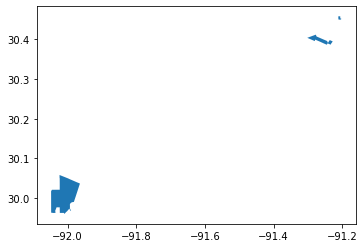

In [36]:
final_not_match = geom_validate1[0]
precincts_not_match = geom_validate1[0]
final_not_match = final_not_match[final_not_match['GEOM_EQUALS']==False]
precincts_not_match = precincts_not_match[precincts_not_match['GEOM_EQUALS']==False]
final_not_match.plot()

<AxesSubplot:>

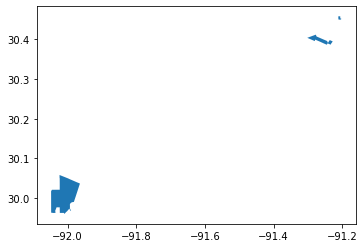

In [37]:
precincts_not_match.plot()

## Join the election data to the precinct shapefile

In [38]:
election_data = election_data[['G16PRERTRU', 'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOMCM',
       'G16PRECCAS', 'G16PREOOTH', 'G16USSRKEN',
       'G16USSRBOU', 'G16USSRFLE', 'G16USSRMAN', 'G16USSRDUK', 'G16USSRCRA',
       'G16USSRCAO', 'G16USSRMAR', 'G16USSRPAT', 'G16USSDCAM', 'G16USSDFAY',
       'G16USSDEDW', 'G16USSDLAN', 'G16USSDPEL', 'G16USSDWIL', 'G16USSDMEN',
       'G16USSLCLE', 'G16USSLGIL', 'G16USSOLAN', 'G16USSOTAY', 'G16USSNBIL',
       'G16USSNHEB', 'G16USSNMAR', 'G16USSNWEL', 'R16USSRKEN', 'R16USSDCAM','Code']]
election_data.head()

,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOMCM,G16PRECCAS,G16PREOOTH,G16USSRKEN,G16USSRBOU,G16USSRFLE,G16USSRMAN,G16USSRDUK,G16USSRCRA,G16USSRCAO,G16USSRMAR,G16USSRPAT,G16USSDCAM,G16USSDFAY,G16USSDEDW,G16USSDLAN,G16USSDPEL,G16USSDWIL,G16USSDMEN,G16USSLCLE,G16USSLGIL,G16USSOLAN,G16USSOTAY,G16USSNBIL,G16USSNHEB,G16USSNMAR,G16USSNWEL,R16USSRKEN,R16USSDCAM,Code
0,920.0,99.0,15.0,8.0,3.0,1.0,0.0,208.0,485.0,32.0,103.0,44.0,9.0,7.0,1.0,3.0,49.0,30.0,4.0,5.0,0.0,1.0,1.0,11.0,1.0,1.0,0.0,14.0,8.0,0.0,0.0,391.0,67.0,Acadia1-1
1,337.0,44.0,8.0,7.0,0.0,1.0,0.0,72.0,192.0,24.0,32.0,5.0,8.0,0.0,0.0,2.0,14.0,16.0,2.0,6.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,0.0,102.0,30.0,Acadia1-2A
2,197.0,125.0,2.0,1.0,1.0,0.0,0.0,33.0,134.0,13.0,16.0,5.0,7.0,4.0,0.0,0.0,34.0,33.0,6.0,6.0,0.0,5.0,0.0,3.0,1.0,0.0,0.0,2.0,1.0,3.0,1.0,163.0,17.0,Acadia1-2B
3,482.0,47.0,8.0,1.0,0.0,1.0,6.0,118.0,270.0,22.0,39.0,11.0,9.0,4.0,0.0,0.0,29.0,16.0,4.0,1.0,5.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,254.0,35.0,Acadia1-3A
4,275.0,128.0,4.0,4.0,3.0,0.0,3.0,57.0,197.0,6.0,16.0,4.0,2.0,3.0,0.0,0.0,45.0,39.0,3.0,5.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,5.0,1.0,0.0,0.0,88.0,55.0,Acadia1-3B


### Since the election data totals have already been validated to the final data (before and after early vote assignment) we can join the data to the modified precincts geodataframe on the Code field

In [39]:
precincts_joined = pd.merge(precincts_mod,election_data,on=['Code'],how="inner")
print('Number of precincts in the election dataset: ', str(election_data.shape[0]))
print('Number of precincts in the modified precincts dataset: ', str(precincts_mod.shape[0]))
precincts_joined = precincts_joined.sort_values(by=['Final Join']) #sort by Final Join field

#Subset the joined field by the necessary column order
precincts_joined = precincts_joined[['STATEFP10', 'COUNTYFP10', 'VTDST10', 'NAME10',
                                     'G16PRERTRU', 'G16PREDCLI', 'G16PRELJOH',
       'G16PREGSTE', 'G16PREOMCM', 'G16PRECCAS', 'G16PREOOTH', 'G16USSRKEN',
       'G16USSRBOU', 'G16USSRFLE', 'G16USSRMAN', 'G16USSRDUK', 'G16USSRCRA',
       'G16USSRCAO', 'G16USSRMAR', 'G16USSRPAT', 'G16USSDCAM', 'G16USSDFAY',
       'G16USSDEDW', 'G16USSDLAN', 'G16USSDPEL', 'G16USSDWIL', 'G16USSDMEN',
       'G16USSLCLE', 'G16USSLGIL', 'G16USSOLAN', 'G16USSOTAY', 'G16USSNBIL',
       'G16USSNHEB', 'G16USSNMAR', 'G16USSNWEL', 'R16USSRKEN', 'R16USSDCAM','geometry','Final Join']]
print('Number of precincts in the joined election and precincts geodataframe: ',str(precincts_joined.shape[0]))
print('Precincts that were successfully joined with election results as a percentage of election result precincts: ', str((precincts_joined.shape[0]/election_data.shape[0])*100))
print('Precincts that were successfully joined with election results as a percentage of the modified precinct geodataframe: ', str((precincts_joined.shape[0]/precincts_mod.shape[0])*100))
preincts_joined = precincts_joined.fillna(0.0)
precincts_joined.head()

Number of precincts in the election dataset:  3701
Number of precincts in the modified precincts dataset:  3701
Number of precincts in the joined election and precincts geodataframe:  3701
Precincts that were successfully joined with election results as a percentage of election result precincts:  100.0
Precincts that were successfully joined with election results as a percentage of the modified precinct geodataframe:  100.0


,STATEFP10,COUNTYFP10,VTDST10,NAME10,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOMCM,G16PRECCAS,G16PREOOTH,G16USSRKEN,G16USSRBOU,G16USSRFLE,G16USSRMAN,G16USSRDUK,G16USSRCRA,G16USSRCAO,G16USSRMAR,G16USSRPAT,G16USSDCAM,G16USSDFAY,G16USSDEDW,G16USSDLAN,G16USSDPEL,G16USSDWIL,G16USSDMEN,G16USSLCLE,G16USSLGIL,G16USSOLAN,G16USSOTAY,G16USSNBIL,G16USSNHEB,G16USSNMAR,G16USSNWEL,R16USSRKEN,R16USSDCAM,geometry,Final Join
316,22,001,1-1,Precinct 1-1,920.0,99.0,15.0,8.0,3.0,1.0,0.0,208.0,485.0,32.0,103.0,44.0,9.0,7.0,1.0,3.0,49.0,30.0,4.0,5.0,0.0,1.0,1.0,11.0,1.0,1.0,0.0,14.0,8.0,0.0,0.0,391.0,67.0,"POLYGON ((-92.26593 30.27902, -92.26591 30.279...",0011-1
321,22,001,1-2A,Precinct 1-2A,337.0,44.0,8.0,7.0,0.0,1.0,0.0,72.0,192.0,24.0,32.0,5.0,8.0,0.0,0.0,2.0,14.0,16.0,2.0,6.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,0.0,102.0,30.0,"POLYGON ((-92.27080 30.23579, -92.27079 30.235...",0011-2A
319,22,001,1-2B,Precinct 1-2B,197.0,125.0,2.0,1.0,1.0,0.0,0.0,33.0,134.0,13.0,16.0,5.0,7.0,4.0,0.0,0.0,34.0,33.0,6.0,6.0,0.0,5.0,0.0,3.0,1.0,0.0,0.0,2.0,1.0,3.0,1.0,163.0,17.0,"POLYGON ((-92.24835 30.23571, -92.24623 30.235...",0011-2B
273,22,001,1-3A,Precinct 1-3A,482.0,47.0,8.0,1.0,0.0,1.0,6.0,118.0,270.0,22.0,39.0,11.0,9.0,4.0,0.0,0.0,29.0,16.0,4.0,1.0,5.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,254.0,35.0,"POLYGON ((-92.27407 30.25554, -92.27420 30.255...",0011-3A
318,22,001,1-3B,Precinct 1-3B,275.0,128.0,4.0,4.0,3.0,0.0,3.0,57.0,197.0,6.0,16.0,4.0,2.0,3.0,0.0,0.0,45.0,39.0,3.0,5.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,5.0,1.0,0.0,0.0,88.0,55.0,"POLYGON ((-92.24842 30.24221, -92.24838 30.238...",0011-3B


### Confirm that the column totals after the join are the same as the VEST file

In [40]:
precincts_joined_tot = get_column_totals(precincts_joined)
print(precincts_joined_tot)
print(final_tot)
print('\n',precincts_joined_tot==final_tot)

{'G16PRERTRU': 1178638.0, 'G16PREDCLI': 780154.0, 'G16PRELJOH': 37978.0, 'G16PREGSTE': 14031.0, 'G16PREOMCM': 8547.0, 'G16PRECCAS': 3129.0, 'G16PREOOTH': 6555.0, 'G16USSRKEN': 482591.0, 'G16USSRBOU': 298008.0, 'G16USSRFLE': 204026.0, 'G16USSRMAN': 90856.0, 'G16USSRDUK': 58606.0, 'G16USSRCRA': 25523.0, 'G16USSRCAO': 21019.0, 'G16USSRMAR': 3684.0, 'G16USSRPAT': 1576.0, 'G16USSDCAM': 337833.0, 'G16USSDFAY': 240917.0, 'G16USSDEDW': 51774.0, 'G16USSDLAN': 45587.0, 'G16USSDPEL': 7395.0, 'G16USSDWIL': 6855.0, 'G16USSDMEN': 4927.0, 'G16USSLCLE': 11370.0, 'G16USSLGIL': 4067.0, 'G16USSOLAN': 1424.0, 'G16USSOTAY': 1151.0, 'G16USSNBIL': 19352.0, 'G16USSNHEB': 9503.0, 'G16USSNMAR': 4108.0, 'G16USSNWEL': 1483.0, 'R16USSRKEN': 536191.0, 'R16USSDCAM': 347816.0}
{'G16PRERTRU': 1178638.0, 'G16PREDCLI': 780154.0, 'G16PRELJOH': 37978.0, 'G16PREGSTE': 14031.0, 'G16PREOMCM': 8547.0, 'G16PRECCAS': 3129.0, 'G16PREOOTH': 6555.0, 'G16USSRKEN': 482591.0, 'G16USSRBOU': 298008.0, 'G16USSRFLE': 204026.0, 'G16USSRMA

## Join the final VEST file with the precinct shapefile with election results for validation

In [41]:
validate = pd.merge(precincts_joined,final_mod, on='Final Join') #merge on the 'Final Join column'
validate_outer = pd.merge(precincts_joined,final_mod,on='Final Join',how='outer',indicator = True)
validate_outer = validate_outer[validate_outer['_merge']!='both']
print('Number of precincts in the joined precincts dataset: ', str(precincts_joined.shape[0]))
print('Number of precincts in the modified final VEST dataset: ', str(final_mod.shape[0]))
print('Number of precincts in the joined precinct and final VEST file : ',str(validate.shape[0]))
print('Precincts with election results that were successfully joined with the final file as a percentage of the precinct election results geodataframe: ', str((validate.shape[0]/precincts_joined.shape[0])*100))
print('Precincts with election results that were successfully joined with the final file as a percentage of the precincts in the final file: ', str((validate.shape[0]/final_mod.shape[0])*100))
validate_outer.head(50)
validate = validate.fillna(0)

Number of precincts in the joined precincts dataset:  3701
Number of precincts in the modified final VEST dataset:  3701
Number of precincts in the joined precinct and final VEST file :  3701
Precincts with election results that were successfully joined with the final file as a percentage of the precinct election results geodataframe:  100.0
Precincts with election results that were successfully joined with the final file as a percentage of the precincts in the final file:  100.0


### Write a function for ward-by-ward comparision of the election and demographic data

In [42]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff != 0):
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]['Final Join'])
                if (diff>max_diff):
                    print("New max diff is: ", str(max_diff))
                    max_diff = diff
                    print(df.iloc[j]['Final Join'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]['Final Join'])
        else:
            matching_rows +=1
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    print("The median difference is: ", str(np.median(diff_values)))

### Run the ward-by-ward function for the joined gdf

In [43]:
column_List = ['G16PRERTRU', 'G16PREDCLI', 'G16PRELJOH',
       'G16PREGSTE', 'G16PREOMCM', 'G16PRECCAS', 'G16PREOOTH', 'G16USSRKEN',
       'G16USSRBOU', 'G16USSRFLE', 'G16USSRMAN', 'G16USSRDUK', 'G16USSRCRA',
       'G16USSRCAO', 'G16USSRMAR', 'G16USSRPAT', 'G16USSDCAM', 'G16USSDFAY',
       'G16USSDEDW', 'G16USSDLAN', 'G16USSDPEL', 'G16USSDWIL', 'G16USSDMEN',
       'G16USSLCLE', 'G16USSLGIL', 'G16USSOLAN', 'G16USSOTAY', 'G16USSNBIL',
       'G16USSNHEB', 'G16USSNMAR', 'G16USSNWEL', 'R16USSRKEN', 'R16USSDCAM']

In [44]:
validater_row(validate,column_List)

New max diff is:  0
0011-1
New max diff is:  1.0
00537
New max diff is:  2.0
0651
There are  3701  total rows
3676  of these rows have election result differences
25  of these rows are the same

The max difference between any one shared column in a row is:  3.0
The average difference is:  1.0016535411003056
The median difference is:  1.0


### Write a function to check the totals on the jonied dataframe

In [45]:
def sum_checker (df, column_List):
    """Checks the sums of different columns and prints out the maximum difference by column. 
    Assumes that the dataframe is the merged dataframe between RDH and the partner, with the same named election result
    columns, except RDH is _x and Partner is _y. 
    """
    list_max = 0
    for i in column_List:
        left_sum = df[i+"_x"].sum()
        right_sum = df[i+"_y"].sum()
        if (left_sum==right_sum):
            print("Column: ", i, " have the same sums")
            
        else:
            diff = abs(left_sum-right_sum)
            percent = abs(left_sum-right_sum)/left_sum
            print("Column: ", i)
            print("RDH sum is ", str(left_sum))
            print("Partner sum is ", str(right_sum))
            print("Their (absolute) difference is ",str(diff))
            print("As a percentage of DF1 this is ", str(round(percent*100,5)) + "%")
            if (percent>list_max):
                list_max = percent
            print("")
    print("The max difference (as a percent of the total of one DF column) is: ", str(round(list_max,5)))

In [46]:
### Run the sum checker

In [47]:
sum_checker(validate,column_List)

Column:  G16PRERTRU  have the same sums
Column:  G16PREDCLI  have the same sums
Column:  G16PRELJOH  have the same sums
Column:  G16PREGSTE  have the same sums
Column:  G16PREOMCM  have the same sums
Column:  G16PRECCAS  have the same sums
Column:  G16PREOOTH  have the same sums
Column:  G16USSRKEN  have the same sums
Column:  G16USSRBOU  have the same sums
Column:  G16USSRFLE  have the same sums
Column:  G16USSRMAN  have the same sums
Column:  G16USSRDUK  have the same sums
Column:  G16USSRCRA  have the same sums
Column:  G16USSRCAO  have the same sums
Column:  G16USSRMAR  have the same sums
Column:  G16USSRPAT  have the same sums
Column:  G16USSDCAM  have the same sums
Column:  G16USSDFAY  have the same sums
Column:  G16USSDEDW  have the same sums
Column:  G16USSDLAN  have the same sums
Column:  G16USSDPEL  have the same sums
Column:  G16USSDWIL  have the same sums
Column:  G16USSDMEN  have the same sums
Column:  G16USSLCLE  have the same sums
Column:  G16USSLGIL  have the same sums
